<a href="https://colab.research.google.com/github/MichelleAppel/Importance_sampling/blob/master/experiments_multilabel/Toy_example_estimation_of_Radon-Nikodym_derivative_MNIST_multilabel_one_sided_batch_sampling_f_tries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toy example estimation of Radon-Nikodym derivative for MNIST dataset (one sided) with importance sampling

Equation (5) of the paper by Binkowski et al. explains that the Radon-Nikodym derivative $\frac{d \mathbb{Q}_y}{ \mathbb{P}_y^G}$ of the two domains exist under the assumptions they state. This derivative can also be seen as the ratio between the two distributions of the domains, and can be used to express the compensation for imbalance in the domains:

$\mathbb{E}_{Y \sim \mathbb{Q}_y}[D(Y)] = \mathbb{E}_{X \sim \mathbb{P}_x}[D(G(X)) \frac{d \mathbb{Q}_y}{ d\mathbb{P}_y^G}(G(X))]$

This expresses compensation for imbalance between the discriminator outputs, caused by the imbalance in the domain distributions. However, it does not necessarily have to be used for the imbalance in the discriminator outputs. It can be applied to any imbalance caused by the different domain distributions.

--

In other words, we are trying to study the situation where we don't deal with a discriminator but with any function, let it be $f$. This $f$ can be any function, e.g. identity, mean.... We try to compensate for imbalances in the two domains over which we compute the function:

$\mathbb{E}_{Y \sim \mathbb{Q}_y}[f(Y)] = \mathbb{E}_{X \sim \mathbb{P}_x}[f(G(X)) \frac{d \mathbb{Q}_y}{ d\mathbb{P}_y^G}(G(X))]$

Possible functions $f$ for MNIST:
* use the label
* pre-trained classifier

In this toy example we use try different possibilities for $f$:


0.   $f$ = real value for the label of the image (Like in Toy_example_estimation_of_Radon-Nikodym_derivative_MNIST_one_sided_batch_sampling.ipynb : https://colab.research.google.com/drive/1-7Gy2MGhW8mgWU69OiUI6eRboKSftzFp#scrollTo=8rTofkmfJaM3)
1.   $f$ = mean of the pixel value over the whole image
2.   $f$ = image itself, that is weighted by the image's weight (and, after the weighting, an operation like a sum is applid over the whole batch)
3.   $f$ = fixed (not trained) randomly initialized neural network
4.   $f$ = fixed (not trained) randomly initialized neural network, with possibility to use hidden variables as $f$. $f$ can also be a tensor instead of a single value  




--

This toy example uses a simplified version of MNIST.

The dataset only has zeroes and ones, and the percentage of zeros/ones is specified by the user

--

The following toy example shows how we can use the Radon-Nikodym derivative for compensating the imbalance for the mean of the domains using $\bar{Y} = \bar{X}\frac{d \mathbb{Q}_y}{d \mathbb{P}_x}$.


Let $X = [1, 1, 1, 1, 1, 1, 1, 0, 0]$, with mean $\bar{X} = 0.8$ and <br />
Let $Y = [1, 1, 0, 0, 0, 0, 0, 0, 0]$, with mean $\bar{Y} = 0.2$

Then $[1, 1, 0, 0, 0, 0, 0, 0, 0] = [1, 1, 1, 1, 1, 1, 1, 0, 0] \cdot \frac{d \mathbb{Q}_y}{d \mathbb{P}_x}(X)$, and <br />
$\frac{d \mathbb{Q}_y}{d \mathbb{P}_x}(X) = [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 4, 4]$

This can be interpreted as the ratio between means of the domains for each of the samples. In this example the ratio can be calculated. However, in more complex situations, for example with images, the Radon-Nykodym derivative $\frac{d \mathbb{Q}_y}{d \mathbb{P}_x}$ is unknown and we may try to estimate it using a neural network $W$. This leads to the objective function

$\inf_{W \in \mathcal{W}} (\mathbb{E}_{X \sim \mathbb{P}_x} [D(G(X)) \cdot W(X)] - \mathbb{E}_{Y \sim \mathbb{Q}_y}[D(Y)])^2$

used by Binkowski et al. for compensation of distributions in the domains, using the discriminator output. Similarly, we can use such a network in our toy example.

###Initializations

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
import torchvision
import numpy as np

import itertools

import matplotlib.pyplot as plt

In [2]:
def visualize_img_batch(batch):
    '''Visualizes image batch
    
    Parameters:
    batch (Tensor): An image batch
    '''
    
    print("*** batch ***")
    print('Batch dim:' + str(batch.shape[0]))
    print('0 :' + str((batch==0.0).sum().item()))
    print('1 :' + str((batch==1.0).sum().item()))
    print('2 :' + str((batch==2.0).sum().item()))
    print('3 :' + str((batch==3.0).sum().item()))
    print('4 :' + str((batch==4.0).sum().item()))
    print('5 :' + str((batch==5.0).sum().item()))
    print('6 :' + str((batch==6.0).sum().item()))
    print('7 :' + str((batch==7.0).sum().item()))
    print('8 :' + str((batch==8.0).sum().item()))
    print('9 :' + str((batch==9.0).sum().item()))

    batch_formatted = torch.tensor(batch[:64]).unsqueeze(1).cuda() 
    for i in range(8):
      #print('{} {} {} {} {} {} {} {} {} {}'.format(batch[]))
      string = ''
      for j in range(8):
        string = string + ' {}'.format(int(batch_formatted[i*8+j][0]))
      print(string)


In [3]:
def visualize_MNIST_img_batch(batch):
    '''Visualizes image batch for MNIST
    
    Parameters:
    batch (Tensor): An image batch
    '''
    fig = plt.figure()
    for i in range(batch.shape[0]):
      plt.subplot(1,batch.shape[0],i+1)
      plt.tight_layout()
      plt.imshow(batch[i], cmap='gray', interpolation='none')
      plt.title("Ground Truth: {}".format(i))
      plt.xticks([])
      plt.yticks([])

In [4]:
def MNIST_binary_data(ratio=0.5):
    # ratio: ratio between zeroes and ones, i.e. number_zeroes / (number_zeroes + number_ones)
    # returns (data, labels) for MNIST with all the classes; zeroes and ones the given ratio

    MNIST = torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
    
    idxm0 = MNIST.train_labels==0
    idxm1 = MNIST.train_labels==1 
    idxm2 = torch.logical_and(MNIST.train_labels!=0, MNIST.train_labels!=1)
    dim = len(idxm0)  

    n0 = torch.sum(idxm0)
    n1 = torch.sum(idxm1)
    tot = n0 + n1

    if ratio < n0.item()/tot.item():  # if there are too many zeroes, take just the first zeroes until reaching the ratio
      if ratio == 1:
        size = n0
      else:
        size = int(n1/(1-ratio))
      idx0 = np.where(idxm0)[0]
      idx0 = idx0[:int(size*ratio)]
      idx1 = np.where(idxm1)[0]
    else:                              # if there are too many ones, take just the first zeroes until reaching the ratio
      if ratio == 1:
        size = n1
      else:
        size = int(n0/ratio)
      idx0 = np.where(idxm0)[0]
      idx1 = np.where(idxm1)[0]
      idx1 = idx1[:int(size*(1-ratio))]

    # index of images in the wole dataset to be kept
    idx2 = np.where(idxm2)[0]
    idx = torch.sort(torch.tensor(idx0.tolist() + idx1.tolist() + idx2.tolist())).values
    #print(idx)
    #idxm = torch.tensor( [True if i in idx else False for i in range(dim)] )

    # assign the new data and labels to the dataset
    MNIST.targets = MNIST.train_labels[idx]
    MNIST.data = MNIST.train_data[idx]

    return MNIST 
'''
# TEST
ratio = 0.2
res = MNIST_binary_data(ratio)
#print(res)
#print(res.targets.tolist()) #labels
#print(res.data) #data

zeroes = (res.train_labels==0).sum().item()
ones = (res.train_labels==1).sum().item()
tot = zeroes + ones
print('ratio zeroes/(zeroes + ones) =' + str(zeroes/tot) + ' (intended =' + str(ratio) + ')')

print(res)
print('0 =' + str((res.train_labels==0).sum().item()))
print('1 =' + str((res.train_labels==1).sum().item()))
print('2 =' + str((res.train_labels==2).sum().item()))
print('3 =' + str((res.train_labels==3).sum().item()))
print('4 =' + str((res.train_labels==4).sum().item()))
print('5 =' + str((res.train_labels==5).sum().item()))
print('6 =' + str((res.train_labels==6).sum().item()))
print('7 =' + str((res.train_labels==7).sum().item()))
print('8 =' + str((res.train_labels==8).sum().item()))
print('9 =' + str((res.train_labels==9).sum().item()))'''

"\n# TEST\nratio = 0.2\nres = MNIST_binary_data(ratio)\n#print(res)\n#print(res.targets.tolist()) #labels\n#print(res.data) #data\n\nzeroes = (res.train_labels==0).sum().item()\nones = (res.train_labels==1).sum().item()\ntot = zeroes + ones\nprint('ratio zeroes/(zeroes + ones) =' + str(zeroes/tot) + ' (intended =' + str(ratio) + ')')\n\nprint(res)\nprint('0 =' + str((res.train_labels==0).sum().item()))\nprint('1 =' + str((res.train_labels==1).sum().item()))\nprint('2 =' + str((res.train_labels==2).sum().item()))\nprint('3 =' + str((res.train_labels==3).sum().item()))\nprint('4 =' + str((res.train_labels==4).sum().item()))\nprint('5 =' + str((res.train_labels==5).sum().item()))\nprint('6 =' + str((res.train_labels==6).sum().item()))\nprint('7 =' + str((res.train_labels==7).sum().item()))\nprint('8 =' + str((res.train_labels==8).sum().item()))\nprint('9 =' + str((res.train_labels==9).sum().item()))"

In [5]:
def MNIST_data(distribution=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]):
    # distribution: distribution for each label
    # returns (data, labels) for MNIST with all the classes; zeroes and ones have the given distribution

    MNIST = torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
    
    softm = nn.Softmax()
    #print(distribution)
    distribution = softm(torch.tensor(distribution))
    #print(distribution)
    
    tot = torch.tensor(distribution).sum().item()
    #print(tot)
    #if tot > 1:
    #  print("Invalid value")
    #  return MNIST

    # bool mask for each label
    idxm = [MNIST.train_labels==label for label in range(10)]
    #print(idxm)

    # list of indices for each label
    idx = [np.where(idxm[label])[0] for label in range(10)]
    #print(idx)

    # compute the tot. number of elements in the result:
    # - for each label there's the desired percentage in the result, and the number of images -> the max number of contribution in the result is tot_samples / desired_percentage
    # - the tot. number of elements in the result is the minimum across all the labels 
    tot_labels = [(MNIST.train_labels==label).sum().item() for label in range(10)]
    dim_res = [tot_labels[label] / distribution[label] for label in range(10)]
    dim_res = int(min(dim_res)) / 2

    # list of valid indices (i.e. indices for the result) for each label
    valid_idx_labels = [[] for label in range(10)]
    valid_idx = []
    for label in range(10):
      number_samples = distribution[label] * dim_res
      valid_idx_labels[label] = idx[label][:int(number_samples)]
      valid_idx = valid_idx + valid_idx_labels[label].tolist()
    # sort
    #print(valid_idx)
    valid_idx = torch.sort(torch.tensor(valid_idx)).values
    #print(valid_idx)

    # assign the new data and labels to the dataset
    MNIST.targets = MNIST.train_labels[valid_idx]
    MNIST.data = MNIST.train_data[valid_idx]

    return MNIST 
'''
# TEST
distribution = [0.15, 0.15, 0.15, 0.15, 0.15, 0.5, 0.5, 0.5, 0.5, 0.5]
res = MNIST_data(distribution)
#print(res)
#print(res.targets.tolist()) #labels
#print(res.data) #data

print(res)
print('0 =' + str((res.train_labels==0).sum().item()))
print('1 =' + str((res.train_labels==1).sum().item()))
print('2 =' + str((res.train_labels==2).sum().item()))
print('3 =' + str((res.train_labels==3).sum().item()))
print('4 =' + str((res.train_labels==4).sum().item()))
print('5 =' + str((res.train_labels==5).sum().item()))
print('6 =' + str((res.train_labels==6).sum().item()))
print('7 =' + str((res.train_labels==7).sum().item()))
print('8 =' + str((res.train_labels==8).sum().item()))
print('9 =' + str((res.train_labels==9).sum().item()))'''

"\n# TEST\ndistribution = [0.15, 0.15, 0.15, 0.15, 0.15, 0.5, 0.5, 0.5, 0.5, 0.5]\nres = MNIST_data(distribution)\n#print(res)\n#print(res.targets.tolist()) #labels\n#print(res.data) #data\n\nprint(res)\nprint('0 =' + str((res.train_labels==0).sum().item()))\nprint('1 =' + str((res.train_labels==1).sum().item()))\nprint('2 =' + str((res.train_labels==2).sum().item()))\nprint('3 =' + str((res.train_labels==3).sum().item()))\nprint('4 =' + str((res.train_labels==4).sum().item()))\nprint('5 =' + str((res.train_labels==5).sum().item()))\nprint('6 =' + str((res.train_labels==6).sum().item()))\nprint('7 =' + str((res.train_labels==7).sum().item()))\nprint('8 =' + str((res.train_labels==8).sum().item()))\nprint('9 =' + str((res.train_labels==9).sum().item()))"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


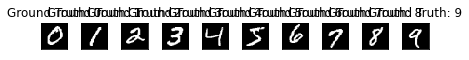

In [6]:
class MNISTDataset(Dataset):
    '''The dataset for the MNIST binary data
    '''
    def __init__(self, distribution = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]):

        self.ratio = distribution
        
        self.dataset = MNIST_data(distribution=self.ratio)
        
        self.example_imgs = self.example()
        
    def example(self):
        '''
        Returns an example from each digit in the domain
        
        '''
        labels = self.dataset.targets
        data = self.dataset.data
        img0 = data[labels==0][0].unsqueeze(0)
        img1 = data[labels==1][0].unsqueeze(0)
        img2 = data[labels==2][0].unsqueeze(0)
        img3 = data[labels==3][0].unsqueeze(0)
        img4 = data[labels==4][0].unsqueeze(0)
        img5 = data[labels==5][0].unsqueeze(0)
        img6 = data[labels==6][0].unsqueeze(0)
        img7 = data[labels==7][0].unsqueeze(0)
        img8 = data[labels==8][0].unsqueeze(0)
        img9 = data[labels==9][0].unsqueeze(0)
        ex = torch.cat((img0, img1, img2, img3, img4, img5, img6, img7, img8, img9), 0)
              
        return ex

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):      
        return self.dataset[idx]

# TEST
dataset = MNISTDataset()

fig = plt.figure()
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.tight_layout()
  plt.imshow(dataset.example_imgs[i].cpu(), cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(i))
  plt.xticks([])
  plt.yticks([])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  # Remov


*** Dataset A ***
23100
0 =1910
1 =1910
2 =1910
3 =1910
4 =1910
5 =2710
6 =2710
7 =2710
8 =2710
9 =2710

*** Dataset B ***
27100
0 =2710
1 =2710
2 =2710
3 =2710
4 =2710
5 =2710
6 =2710
7 =2710
8 =2710
9 =2710


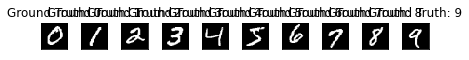

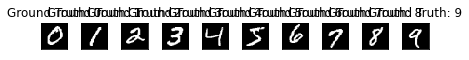

In [7]:
# Settings for domain A (red)
ratio_A = [0.15, 0.15, 0.15, 0.15, 0.15, 0.5, 0.5, 0.5, 0.5, 0.5]
dataset_A = MNISTDataset(distribution=ratio_A)
dataloader_A = DataLoader(dataset_A, batch_size=256, shuffle=True)

# Settings for domain B (green)
ratio_B = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
dataset_B = MNISTDataset(distribution=ratio_B)
dataloader_B = DataLoader(dataset_B, batch_size=256, shuffle=True)

visualize_MNIST_img_batch(dataset_A.example_imgs.cpu())
visualize_MNIST_img_batch(dataset_B.example_imgs.cpu())

print('\n*** Dataset A ***')
print(len(dataset_A))
print('0 =' + str((dataset_A.dataset.train_labels==0).sum().item()))
print('1 =' + str((dataset_A.dataset.train_labels==1).sum().item()))
print('2 =' + str((dataset_A.dataset.train_labels==2).sum().item()))
print('3 =' + str((dataset_A.dataset.train_labels==3).sum().item()))
print('4 =' + str((dataset_A.dataset.train_labels==4).sum().item()))
print('5 =' + str((dataset_A.dataset.train_labels==5).sum().item()))
print('6 =' + str((dataset_A.dataset.train_labels==6).sum().item()))
print('7 =' + str((dataset_A.dataset.train_labels==7).sum().item()))
print('8 =' + str((dataset_A.dataset.train_labels==8).sum().item()))
print('9 =' + str((dataset_A.dataset.train_labels==9).sum().item()))
print('\n*** Dataset B ***')
print(len(dataset_B))
print('0 =' + str((dataset_B.dataset.train_labels==0).sum().item()))
print('1 =' + str((dataset_B.dataset.train_labels==1).sum().item()))
print('2 =' + str((dataset_B.dataset.train_labels==2).sum().item()))
print('3 =' + str((dataset_B.dataset.train_labels==3).sum().item()))
print('4 =' + str((dataset_B.dataset.train_labels==4).sum().item()))
print('5 =' + str((dataset_B.dataset.train_labels==5).sum().item()))
print('6 =' + str((dataset_B.dataset.train_labels==6).sum().item()))
print('7 =' + str((dataset_B.dataset.train_labels==7).sum().item()))
print('8 =' + str((dataset_B.dataset.train_labels==8).sum().item()))
print('9 =' + str((dataset_B.dataset.train_labels==9).sum().item()))

*** Batches distribution ***

*** Batch from domain A ***
*** batch ***
Batch dim:256
0 :20
1 :19
2 :20
3 :22
4 :26
5 :34
6 :30
7 :28
8 :35
9 :22


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


 0 4 8 6 5 6 3 5
 8 2 2 1 4 7 9 2
 9 7 5 1 7 9 1 8
 3 7 6 2 4 4 0 0
 4 0 5 3 3 3 5 2
 8 6 4 0 8 6 9 3
 5 5 2 5 2 4 9 3
 7 3 8 4 7 8 8 8


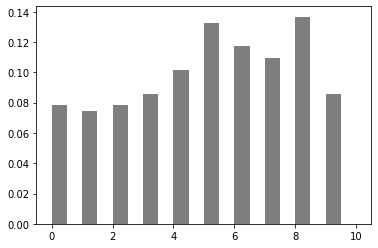


*** Batch from domain B ***
*** batch ***
Batch dim:256
0 :23
1 :27
2 :26
3 :24
4 :27
5 :33
6 :31
7 :20
8 :25
9 :20
 3 7 5 8 8 0 3 7
 6 9 9 1 6 4 3 5
 2 5 3 8 4 4 2 3
 4 1 6 4 9 6 5 1
 6 2 5 3 5 6 0 4
 6 8 0 1 0 5 7 4
 5 1 4 6 8 5 4 1
 5 1 5 5 5 7 6 8


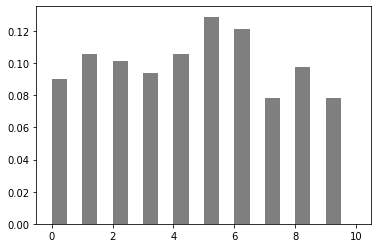

In [8]:
import cv2

def plot_hist(data):
    data = data.squeeze().cpu()
   
    legend = []
    for label in range(10):
      plt.hist(data[data==label], weights=torch.ones(len(data[data==label]))/len(data), 
             color='black', bins=20, range= (0, 10), alpha=0.5)
      legend = legend + ['Imgs for label {}'.format(label)]
    #plt.legend(legend)
    #plt.gca().set_facecolor('xkcd:gray')
    x_unique_count = torch.stack([(data==x_u).sum() for x_u in data.unique()])
    plt.show()

for i, (data_A, data_B) in enumerate(zip(dataloader_A, dataloader_B)):
    labs_A = data_A[1].double()
    labs_B = data_B[1].double()

    print('*** Batches distribution ***')
    print('\n*** Batch from domain A ***')
    visualize_img_batch(labs_A)
    plot_hist(labs_A)
    print('\n*** Batch from domain B ***')
    visualize_img_batch(labs_B)
    plot_hist(labs_B)

    break

In [9]:
class WeightNet(nn.Module):
    '''A simple network that predicts the importances of the samples'''

    def __init__(self):
        super(WeightNet, self).__init__()
#        self.fc1 = nn.Linear(1, 1)
#        self.fc2 = nn.Linear(1, 1)
        self.softmax = nn.Softmax(dim=0)

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 40)
        self.fc2 = nn.Linear(40, 1)

        self.conv1.reset_parameters()
        self.conv2.reset_parameters()
        self.fc1.reset_parameters()
        self.fc2.reset_parameters()
        #nn.init.xavier_normal_(self.conv1.weight)
        #nn.init.xavier_normal_(self.conv2.weight)
        #nn.init.xavier_normal_(self.fc1.weight)
        #nn.init.xavier_normal_(self.fc2.weight)
        
    def forward(self, x):
        x = torch.sigmoid(F.max_pool2d(self.conv1(x), 2))
        x = torch.sigmoid(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return self.softmax(x), x


'''Also tried different architectures for the weight network, but they all do not work (the loss does not go down and the weights assigned to images don't seem to make sense). Following are two examples'''
class WeightNet_2(nn.Module):
    '''This works (it's basically the same as the first one), but without dropout. Adding dropout breakes it'''
    def __init__(self):
        super(WeightNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

        self.softmax = nn.Softmax(dim=0)

    def forward(self, x):
        x = torch.sigmoid(F.max_pool2d(self.conv1(x), 2))
        x = torch.sigmoid(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = torch.sigmoid(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return self.softmax(x), x

class WeightNet_3(nn.Module):
    '''This just has different activation functions. Does not work at all'''
    def __init__(self):
        super(WeightNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x), x

class WeightNet_4(nn.Module):
    '''This does not work'''
    def __init__(self):
        super(WeightNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=5)
        self.conv2 = nn.Conv2d(4, 10, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(160, 50)
        self.fc2 = nn.Linear(50, 1)

        self.softmax = nn.Softmax(dim=0)

    def forward(self, x):
        x = torch.sigmoid(F.max_pool2d(self.conv1(x), 2))
        x = torch.sigmoid(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 160)
        x = torch.sigmoid(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return self.softmax(x), x

class WeightNet_5(nn.Module):
    '''This works without dropout. Adding dropout breakes it'''
    def __init__(self):
        super(WeightNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.fc3 = nn.Linear(10, 1)

        self.softmax = nn.Softmax(dim=0)

    def forward(self, x):
        x = torch.sigmoid(F.max_pool2d(self.conv1(x), 2))
        x = torch.sigmoid(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = torch.sigmoid(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        x = self.fc3(self.fc2(x))
        return self.softmax(x), x

####Compute the average & variance of assigned weights, for each number, in the batches

In [10]:
# compute the average weight/importance assigned to images in the batches, and the variance

import collections

def compute_average_prob(weight_network):
    weights_total = collections.defaultdict(torch.tensor)
    weights_mean = collections.defaultdict(float)
    weights_var = collections.defaultdict(float)
    mean_weight_batch = collections.defaultdict(float)
    ratio01s = []
    unnorm_weights_batch_list = collections.defaultdict(torch.tensor)
    
    for i, (batch_A, batch_B) in enumerate(zip(dataloader_A, dataloader_B)):

        real_A = batch_A[0].cuda()
        labels_A = batch_A[1].cuda()
        weights_batch, unnorm_weights_batch = weight_network(real_A)

        possible_labels, _ = torch.unique(labels_A).sort()
        for l in possible_labels:
            indices_with_label_l = labels_A == l.item()
            if l not in weights_total.keys():
              weights_total[l.item()] = weights_batch[indices_with_label_l]
            else:
              torch.cat((weights_total[l.item()], weights_batch[indices_with_label_l]), 0)
            
            mean_weight_batch[l.item()] = weights_batch[indices_with_label_l].mean().item() # mean weight assigned to '0' and '1' for each batch: p('0',batch_i) and p('1',batch_i)

            if l not in weights_total.keys():
              unnorm_weights_batch_list[l.item()] = torch.exp(unnorm_weights_batch[indices_with_label_l])
            else:
              torch.cat((unnorm_weights_batch_list[l.item()], torch.exp(unnorm_weights_batch[indices_with_label_l])), 0) #all w_i for all i that are '0', lets call this list_0; the same for '1', lets call it list_1

        ratio01s += [mean_weight_batch[0] / mean_weight_batch[1]] # ratio q(batch_i) = p('0',batch_i)/p('1',batch_i)
        
    for key in weights_total.keys():
        weights_mean[key] = weights_total[key].mean().item()
        weights_var[key] = weights_total[key].var().item()
    
    ratio01 = torch.tensor(ratio01s).mean().item() # average over all q(batch_i)

    unnorm_ratio01 = torch.tensor(unnorm_weights_batch_list[0]).mean().item() / torch.tensor(unnorm_weights_batch_list[1]).mean().item() # average over list_0, and independently over list_1, and take the quotient

    return weights_mean, weights_var, ratio01, unnorm_ratio01

#compute_average_prob(weight_network)

### Different functions for f

In [11]:
def f_0(labels_A, labels_B, w):
   '''f = label of the image '''

   L_A  = (labels_A.view(-1) * weight_normalization(w).view(-1)).sum()
   L_B = (labels_B.float()).mean()

   return L_A, L_B

In [12]:
def f_1(sampled_A, real_B, w_sampled):
   '''f = mean of each image '''

   L_A  = (torch.mean(sampled_A, dim=[2,3]).view(-1) * (w_sampled/w_sampled.detach()).view(-1)).sum()
   L_B = (torch.mean(real_B, dim=[2,3])).mean()

   return L_A, L_B

In [13]:
def f_2(real_A, real_B, w):
   '''f = image itself; each image is weighted, and the sum across all images is computed '''

   #L_A  = (real_A * weight_normalization(w).repeat(28,28,1,1).permute(2,3,0,1)).sum()
   #L_B = (real_B).mean()
   
   L_A  = (sampled_A * (w_sampled/w_sampled.detach()).repeat(28,28,1,1).permute(2,3,0,1) ).sum()
   L_B = (real_B).mean()

   return L_A, L_B

In [14]:
class f_Net_2cl2fcl(nn.Module):
    ''' NN with 2 convolutional layers and fully connected layers'''

    def __init__(self):
        super(f_Net_2cl2fcl, self).__init__()
        self.softmax = nn.Softmax(dim=0)

        self.conv1 = nn.Conv2d(1, 4, kernel_size=5, stride = 2)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=5, stride = 2)
        self.fc1 = nn.Linear(128, 36)
        self.fc2 = nn.Linear(36, 1)

        # randomly initialize the network
        nn.init.uniform_(self.conv1.weight)
        nn.init.uniform_(self.conv2.weight)
        nn.init.uniform_(self.fc1.weight)
        nn.init.uniform_(self.fc2.weight)

        # freezes the network (does not update the weights in Grad Desc.)
        for param in self.parameters():
           param.requires_grad = False
        
    def forward(self, x):
        cl1 = torch.sigmoid(self.conv1(x))
        cl2 = torch.sigmoid(self.conv2(cl1))
        cl2 = cl2.view(-1, 128)
        fc1 = torch.sigmoid(self.fc1(cl2))
        fc2 = self.fc2(fc1)
        fc2 = fc2.squeeze()

        # outputs a dictionary
        out = {}
        out['cl1'] = cl1.view(-1, 576) # hidden variables
        out['cl2'] = cl2 # hidden variables
        out['fc1'] = fc1 # hidden variables
        out['out'] = fc2 # output
        
        return out

In [15]:
class f_Net_1cl1fcl(nn.Module):
    ''' NN with 1 convolutional layer and 1 fully connected layer'''

    def __init__(self):
        super(f_Net_1cl1fcl, self).__init__()

        self.conv1 = nn.Conv2d(1, 4, kernel_size=5, stride = 4)
        self.fc2 = nn.Linear(144, 1)

        # randomly initialize the network
        nn.init.uniform_(self.conv1.weight)
        nn.init.uniform_(self.fc2.weight)

        # freezes the network (does not update the weights in Grad Desc.)
        for param in self.parameters():
           param.requires_grad = False
        
    def forward(self, x):
        cl1 = torch.sigmoid(self.conv1(x))
        cl1 = cl1.view(-1, 144)
        fc2 = torch.sigmoid(self.fc2(cl1))
        fc2 = fc2.squeeze()

        # outputs a dictionary
        out = {}
        out['cl1'] = cl1 # hidden variables
        out['out'] = fc2 # output
        
        return out

In [16]:
class f_Net_4fcl(nn.Module):
    ''' NN with 4 fully connected layers'''

    def __init__(self):
        super(f_Net_4fcl, self).__init__()

        self.fc1 = nn.Linear(784, 392)
        self.fc2 = nn.Linear(392, 128)
        self.fc3 = nn.Linear(128, 36)
        self.fc4 = nn.Linear(36, 1)

        # randomly initialize the network
        nn.init.uniform_(self.fc1.weight)
        nn.init.uniform_(self.fc2.weight)
        nn.init.uniform_(self.fc3.weight)
        nn.init.uniform_(self.fc4.weight)

        # freezes the network (does not update the weights in Grad Desc.)
        for param in self.parameters():
           param.requires_grad = False
        
    def forward(self, x):
        x = x.view(-1, 784)
        fc1 = torch.sigmoid(self.fc1(x))
        fc2 = torch.sigmoid(self.fc2(fc1))
        fc3 = torch.sigmoid(self.fc3(fc2))
        fc4 = torch.sigmoid(self.fc4(fc3))
        fc4 = fc4.squeeze()

        # outputs a dictionary
        out = {}
        out['fc1'] = fc1 # hidden variables
        out['fc2'] = fc2 # hidden variables
        out['fc3'] = fc3 # hidden variables
        out['out'] = fc4 # output
        
        return out

In [17]:
class f_Net_3fcl(nn.Module):
    ''' NN with 3 fully connected layers'''

    def __init__(self):
        super(f_Net_3fcl, self).__init__()

        self.fc1 = nn.Linear(784, 392)
        self.fc2 = nn.Linear(392, 36)
        self.fc4 = nn.Linear(36, 1)

        # randomly initialize the network
        nn.init.uniform_(self.fc1.weight)
        nn.init.uniform_(self.fc2.weight)
        nn.init.uniform_(self.fc4.weight)

        # freezes the network (does not update the weights in Grad Desc.)
        for param in self.parameters():
           param.requires_grad = False
        
    def forward(self, x):
        x = x.view(-1, 784)
        fc1 = torch.sigmoid(self.fc1(x))
        fc2 = torch.sigmoid(self.fc2(fc1))
        fc3 = torch.sigmoid(self.fc4(fc2))
        fc3 = fc3.squeeze()

        # outputs a dictionary
        out = {}
        out['fc1'] = fc1 # hidden variables
        out['fc2'] = fc2 # hidden variables
        out['out'] = fc3 # output

        return out

In [18]:
class f_Net_2fcl(nn.Module):
    ''' NN with 2 fully connected layers'''

    def __init__(self):
        super(f_Net_2fcl, self).__init__()

        self.fc1 = nn.Linear(784, 36)
        self.fc4 = nn.Linear(36, 1)

        # randomly initialize the network
        nn.init.uniform_(self.fc1.weight)
        nn.init.uniform_(self.fc4.weight)

        # freezes the network (does not update the weights in Grad Desc.)
        for param in self.parameters():
           param.requires_grad = False
        
    def forward(self, x):
        x = x.view(-1, 784)
        fc1 = torch.sigmoid(self.fc1(x))
        fc2 = torch.sigmoid(self.fc4(fc1))
        fc2 = fc2.squeeze()

        # outputs a dictionary
        out = {}
        out['fc1'] = fc1 # hidden variables
        out['out'] = fc2 # output
        
        return out

In [19]:
class f_Net_1fcl(nn.Module):
    ''' NN with 1 fully connected layer'''

    def __init__(self):
        super(f_Net_1fcl, self).__init__()

        self.fc1 = nn.Linear(784, 1)

        # randomly initialize the network
        nn.init.uniform_(self.fc1.weight)

        # freezes the network (does not update the weights in Grad Desc.)
        for param in self.parameters():
           param.requires_grad = False
        
    def forward(self, x):
        x = x.view(-1, 784)
        x = torch.sigmoid(self.fc1(x))
        x = x.squeeze()
        
        # outputs a dictionary
        out = {}
        out['out'] = x # output
        
        return out

In [20]:
def f_3(real_A, real_b, w):
   '''f = output of a fixed (not-trained and randomly initialized) NN for the image'''
   
   ''' Architectures that work: '''
   #f=f_Net_1fcl().cuda() # 1 fcl
   #f=f_Net_2fcl().cuda() # 2 fcl

   ''' Architectures that do not work: '''
   #f=f_Net_1cl1fcl().cuda() # 1 cl 1 fcl  
   f=f_Net_3fcl().cuda() # 3 fcl
   #f=f_Net_4fcl().cuda() # 4 fcl
   #f=f_Net_2cl2fcl().cuda() # 2 cl 2 fcl
   
   L_A  = (f(real_A)['out'].detach().view(-1) * weight_normalization(w).view(-1)).sum()
   L_B = (f(real_B)['out'].detach()).mean()

   return L_A, L_B

In [21]:
def f_4(real_A, real_b, w):
   '''f = hidden values of a fixed (not-trained and randomly initialized) NN for the image'''
   
   ''' Architectures that work: '''
   #f=f_Net_1fcl().cuda() # 1 fcl
   #f=f_Net_2fcl().cuda() # 2 fcl
   f=f_Net_3fcl().cuda() # 3 fcl : works for f = fc1 or fc2 or out (different behaviour for f = out)
   #f=f_Net_4fcl().cuda() # 4 fcl : works for f = fc1 or fc2 or fc3 or out (different behaviour for f = fc3 or out)
   #f=f_Net_1cl1fcl().cuda() # 1 cl 1 fcl : works for f = cl1 or out (different behaviour for f = out)
   #f=f_Net_2cl2fcl().cuda() # 2 cl 2 fcl : works for f = cl1 or cl2, sometimes it works (with different behaviour) sometimes it doesn't for f = fc1 or out

   ''' Choose which part of the NN to use as f (output or any hidden variable) by selecting the correct entry in the dictionary output of the NN '''
   f_A = f(real_A)['fc1']
   if len(list(f_A.shape)) == 1:
     weights = weight_normalization(w).view(-1)
   else:
     dim = torch.cat([torch.tensor([1]), torch.tensor(f_A.shape[1:]).long()], dim = 0)
     weights = weight_normalization(w).repeat(tuple(dim))
   f_B = f(real_B)['fc1']
   
   L_A  = (f_A.detach() * weights).sum(dim = 0) # if f is a hidden variable, L_A and L_B are tensors, hence the sum(dim = 0)
   L_B = (f_B.detach()).mean(dim = 0)

   return L_A, L_B

###Training

In [22]:
# Initialize the networks
weight_network = WeightNet().cuda()
#print(weight_network.conv1.weight)
#nn.init.uniform_(self.conv2.weight)
#nn.init.uniform_(self.fc1.weight)
#nn.init.uniform_(self.fc2.weight))

# Initialize the optimizers
lr = 0.00035 #0.001
optimizer_w = optim.Adam(weight_network.parameters(), lr=lr)

losses_w = []

mean_A = []
mean_B = []

L_As = []
L_Bs = []

example_importances_A = []
example_importances_B = []

w_means = collections.defaultdict(list)
w_vars = collections.defaultdict(list)
ratio01s = []
unnorm_ratio01s = []

sampled_batch_size = 64

def weight_normalization(w):
    return w
#     return 0.5*(1 + w)

for epoch in range(2):
    for i, (batch_A, batch_B) in enumerate(zip(dataloader_A, dataloader_B)):

        real_A = batch_A[0].cuda()
        real_B = batch_B[0].cuda()
        labels_A = batch_A[1].cuda()
        labels_B = batch_B[1].cuda()

        # The weighting process
        w, unnorm_w = weight_network(real_A)
        
        sampled_idx_A = list( # Sample from batch A according to these importances
            torch.utils.data.sampler.WeightedRandomSampler(w.squeeze(),
                                                           sampled_batch_size, 
                                                           replacement=True))
        w_sampled = w[sampled_idx_A]
        sampled_A = real_A[sampled_idx_A] # The sampled smaller batch A
        sampled_labs_A = labels_A[sampled_idx_A]
    
        # The loss function --------------------------------------------------------------------------------
        
        # Using f as objective function
        L_A, L_B = f_0(labels_A, labels_B, w)
        #L_A, L_B = f_1(sampled_A, real_B, w_sampled)
        #L_A, L_B = f_2(sampled_A, real_B, w_sampled)
        #L_A, L_B = f_3(sampled_A, real_B, w_sampled)
        # L_A, L_B = f_4(sampled_A, real_B, w_sampled)
        
        loss_w = ((L_A - L_B)**2).sum() # if f is a hidden variable, L_A and L_B are tensors, hence the sum() after the square
        
        mean_A += [real_A.mean()]
        mean_B += [real_B.mean()]

        # ---------------------------------------------------------------------------------------------------

        # Backward
        optimizer_w.zero_grad()
        loss_w.backward()
        optimizer_w.step()   

        # Store values --------------------------------------------------------------------------------------
        L_As += [L_A.sum().item()] # if f is a hidden variable, L_A and L_B are tensors, hence the sum()
        L_Bs += [L_B.sum().item()]
        
        losses_w += [loss_w.item()]
        
        w_a = weight_normalization((weight_network(dataset_A.example_imgs.float().unsqueeze(1).cuda())[0]))
        example_importances_A += [(w_a[0].item(), w_a[1].item(), w_a[2].item(), w_a[3].item(), w_a[4].item(), w_a[5].item(), w_a[6].item(), w_a[7].item(), w_a[8].item(), w_a[9].item())] # Store examples in a list

        if i % 20 == 0: # compute avg and var every 5 steps because it's quite slow
          mean, var, ratio01, unnorm_ratio01 = compute_average_prob(weight_network)
          for key in mean.keys():
            if (key not in w_means.keys()):
              w_means[key] = []
              w_vars[key] = [] 
            w_means[key] += [mean[key]]
            w_vars[key] += [var[key]]
          ratio01s += [ratio01]
          unnorm_ratio01s += [unnorm_ratio01]

        # ---------------------------------------------------------------------------------------------------

        # Print statistics
        if i % 20 == 0:
            print('epoch', epoch,'step', i, 'loss_w: ', loss_w.item())
            
        if i % 5000 == 0 and i != 0:
            break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch 0 step 0 loss_w:  0.14713121950626373
epoch 0 step 20 loss_w:  0.2072897106409073
epoch 0 step 40 loss_w:  0.4347178041934967
epoch 0 step 60 loss_w:  0.31742846965789795
epoch 0 step 80 loss_w:  0.09362476319074631
epoch 1 step 0 loss_w:  0.010250921361148357
epoch 1 step 20 loss_w:  4.0376553442911245e-06
epoch 1 step 40 loss_w:  0.01743154600262642
epoch 1 step 60 loss_w:  0.12637227773666382
epoch 1 step 80 loss_w:  0.0022741914726793766


###Results

####Average & variance of assigned weights, for each number, in the batches

In [23]:
# compute the average weight/importance assigned to images in the batches, and the variance

mean, var, ratio01, unnorm_ratio01 = compute_average_prob(weight_network)

# print stats
print("Means: ", mean)
print("Variance: ", var)
print("Ratio01: ", ratio01)
print("Not normalized ratio01: ", unnorm_ratio01)

Means:  defaultdict(<class 'float'>, {0: 0.020372575148940086, 1: 0.018516015261411667, 2: 0.021393414586782455, 3: 0.017753303050994873, 4: 0.015348815359175205, 5: 0.015939243137836456, 6: 0.017552725970745087, 7: 0.012644568458199501, 8: 0.01431678794324398, 9: 0.013089379295706749})
Variance:  defaultdict(<class 'float'>, {0: 1.2043615242873784e-05, 1: 1.9205506760044955e-05, 2: 1.865556805569213e-05, 3: 6.545842097693821e-06, 4: 1.669621815381106e-05, 5: 2.73476848633436e-06, 6: 3.1957913506630575e-06, 7: 2.178681370423874e-06, 8: 1.7901046476254123e-06, 9: 2.906070676544914e-06})
Ratio01:  1.1826952695846558
Not normalized ratio01:  1.100267913217377


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


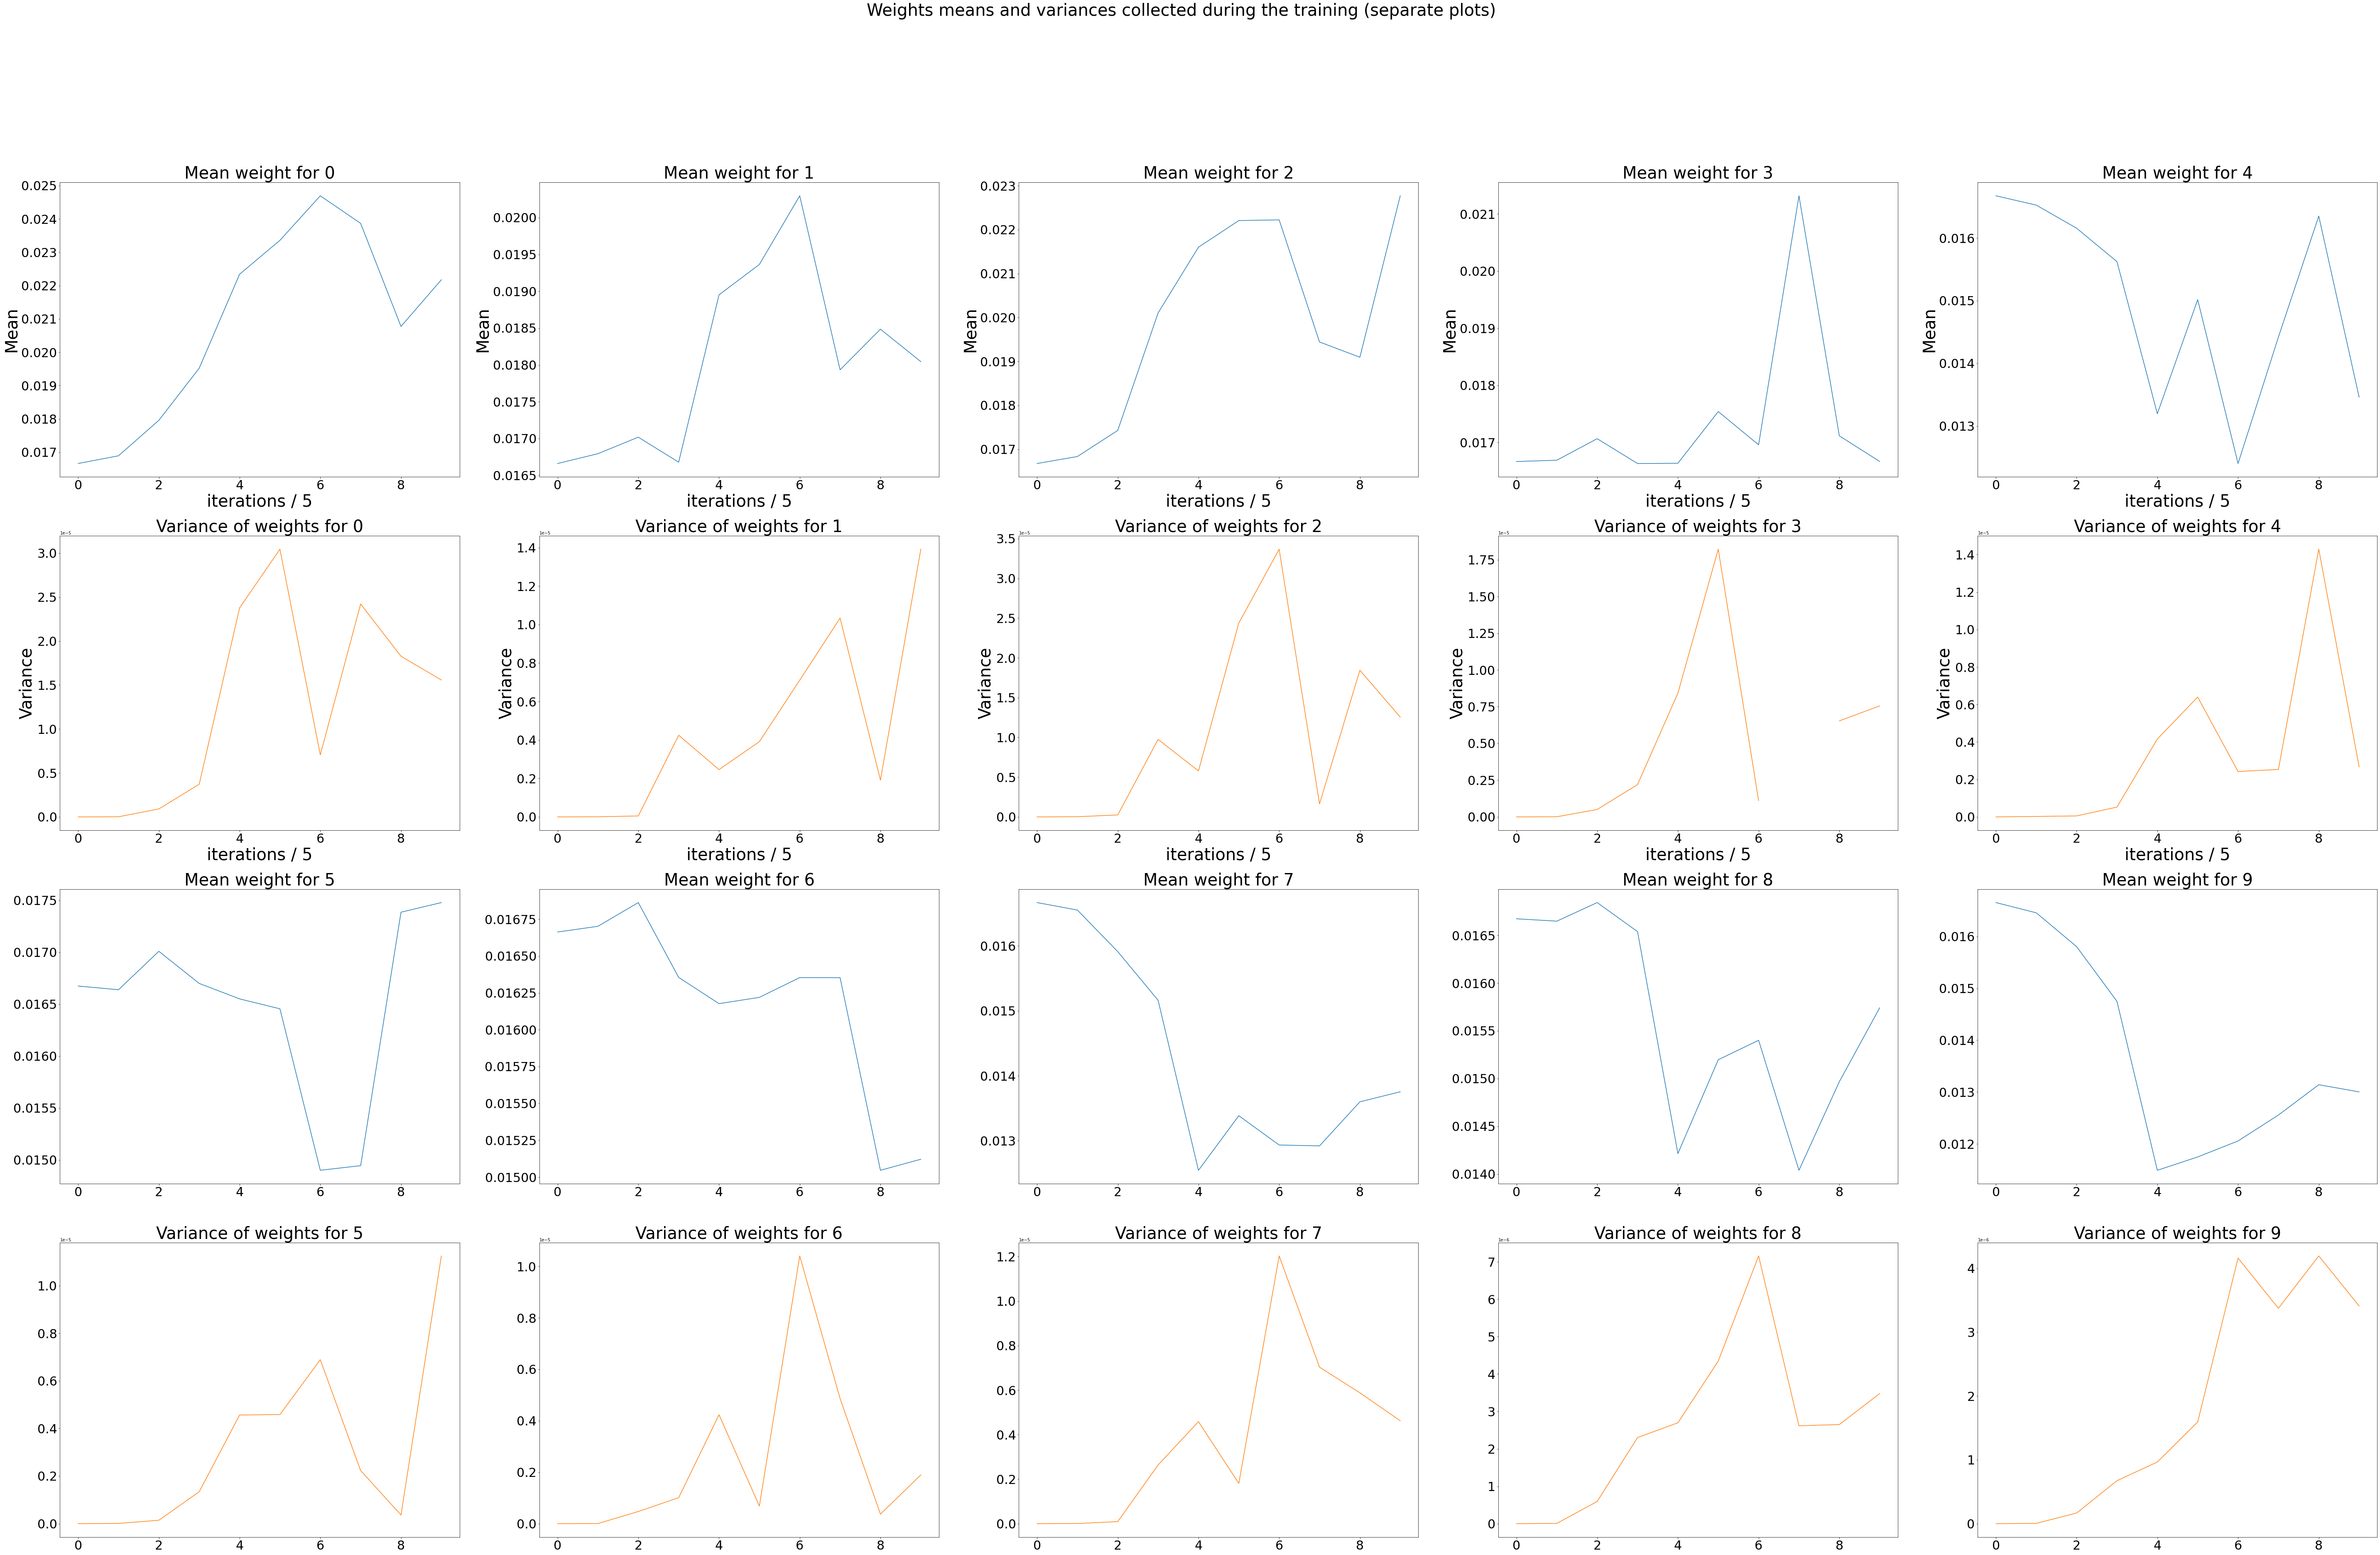

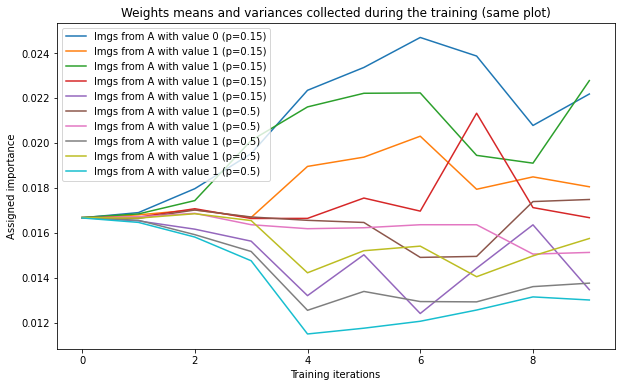

In [24]:
# plot means and variances collected during the training
fig, axs = plt.subplots(4, 5, figsize=(100,60))
fig.suptitle('Weights means and variances collected during the training (separate plots)', fontsize = 40)
for label in range(5):
  axs[0, label].plot(w_means[label])
  axs[0, label].set_title('Mean weight for {}'.format(label), fontsize = 40)
  axs[1, label].plot(w_vars[label], 'tab:orange')
  axs[1, label].set_title('Variance of weights for {}'.format(label), fontsize = 40)
for label in range(5, 10):
  axs[2, label-5].plot(w_means[label])
  axs[2, label-5].set_title('Mean weight for {}'.format(label), fontsize = 40)
  axs[3, label-5].plot(w_vars[label], 'tab:orange')
  axs[3, label-5].set_title('Variance of weights for {}'.format(label), fontsize = 40)

for ax in axs[0,:]:
  ax.set(xlabel='iterations / 5', ylabel='Mean')
for ax in axs[1,:]:
  ax.set(xlabel='iterations / 5', ylabel='Variance')

for i in range(4):
  for ax in axs[i, :]:
    ax.xaxis.label.set_size(40)
    ax.yaxis.label.set_size(40)
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.tick_params(axis='both', which='minor', labelsize=30)


plt.figure(figsize=(10,6))
plt.title('Weights means and variances collected during the training (same plot)')
for label in range(10):
  plt.plot(w_means[label])
plt.legend(['Imgs from A with value {} (p={})'.format(0, ratio_A[0]), 
            'Imgs from A with value {} (p={})'.format(1, ratio_A[1]), 
            'Imgs from A with value {} (p={})'.format(1, ratio_A[2]), 
            'Imgs from A with value {} (p={})'.format(1, ratio_A[3]), 
            'Imgs from A with value {} (p={})'.format(1, ratio_A[4]), 
            'Imgs from A with value {} (p={})'.format(1, ratio_A[5]), 
            'Imgs from A with value {} (p={})'.format(1, ratio_A[6]), 
            'Imgs from A with value {} (p={})'.format(1, ratio_A[7]), 
            'Imgs from A with value {} (p={})'.format(1, ratio_A[8]), 
            'Imgs from A with value {} (p={})'.format(1, ratio_A[9])])
plt.ylabel('Assigned importance')
plt.xlabel('Training iterations')
plt.show()

####Losses

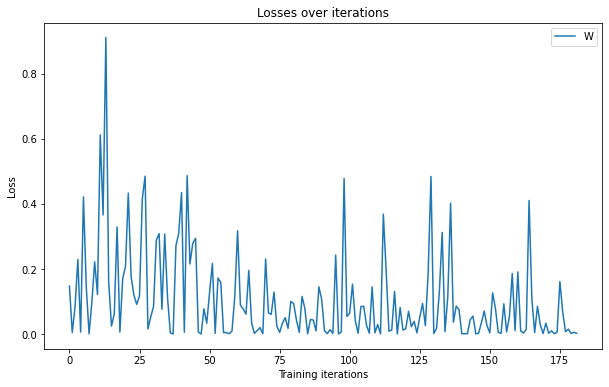

In [25]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
# plt.yscale('symlog')
plt.plot(losses_w)
plt.legend(['W'])
plt.show()

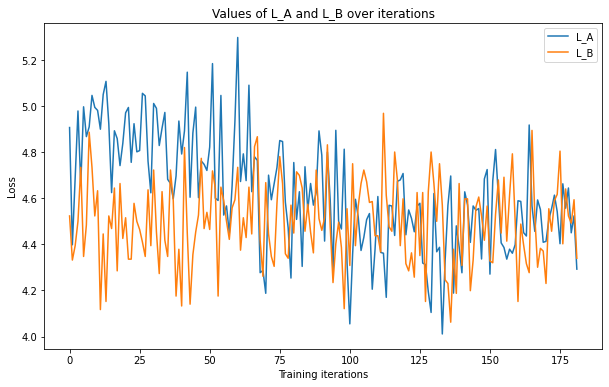

In [26]:
plt.figure(figsize=(10,6))
plt.title('Values of L_A and L_B over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.plot(L_As)
plt.plot(L_Bs)
plt.legend(['L_A', 'L_B'])
plt.show()

####Assigned importances for the example images over the course of training

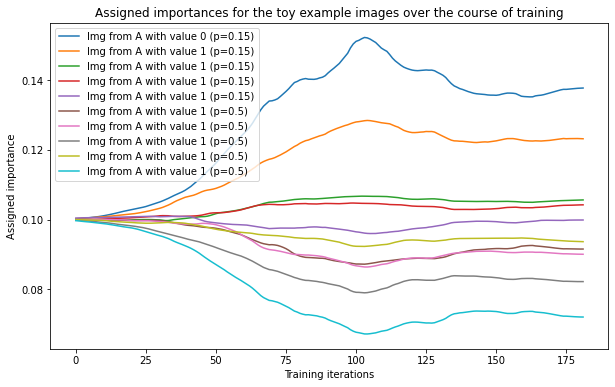

(0.13776715099811554,
 0.12319396436214447,
 0.10562408715486526,
 0.10421749949455261,
 0.09986067563295364,
 0.09152024984359741,
 0.09002123773097992,
 0.08216730505228043,
 0.09363721311092377,
 0.07199060916900635)

In [27]:
plt.figure(figsize=(10,6))
plt.title('Assigned importances for the toy example images over the course of training')
plt.plot(example_importances_A)
plt.legend(['Img from A with value {} (p={})'.format(0, ratio_A[0]), 
            'Img from A with value {} (p={})'.format(1, ratio_A[1]), 
            'Img from A with value {} (p={})'.format(1, ratio_A[2]), 
            'Img from A with value {} (p={})'.format(1, ratio_A[3]), 
            'Img from A with value {} (p={})'.format(1, ratio_A[4]), 
            'Img from A with value {} (p={})'.format(1, ratio_A[5]), 
            'Img from A with value {} (p={})'.format(1, ratio_A[6]), 
            'Img from A with value {} (p={})'.format(1, ratio_A[7]), 
            'Img from A with value {} (p={})'.format(1, ratio_A[8]), 
            'Img from A with value {} (p={})'.format(1, ratio_A[9])])
plt.ylabel('Assigned importance')
plt.xlabel('Training iterations')
plt.show()

example_importances_A[-1]

####Assigned importances for the linear combination of the example images

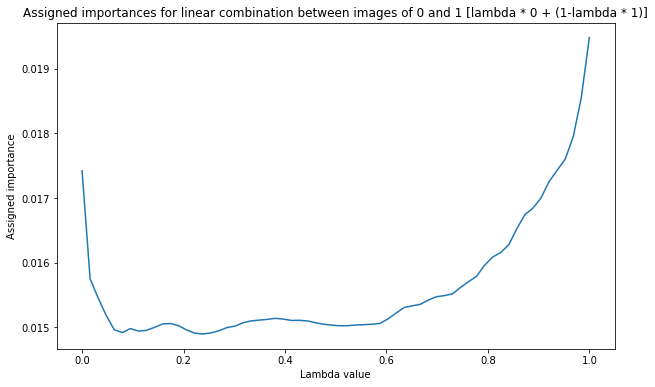

In [28]:
lambd = torch.linspace(0, 1, 64).repeat(28,28,1,1).permute(3,2,0,1)
lin_comb = lambd * dataset_A.example_imgs[0] + (1-lambd) * dataset_A.example_imgs[1]

weights, _ = weight_network(lin_comb.cuda())
weights = weights.cpu().detach().numpy()
plt.figure(figsize=(10,6))
plt.title('Assigned importances for linear combination between images of 0 and 1 [lambda * 0 + (1-lambda * 1)]')
plt.plot(torch.linspace(0, 1, 64), weights)
plt.ylabel('Assigned importance')
plt.xlabel('Lambda value')
plt.show()

####Other

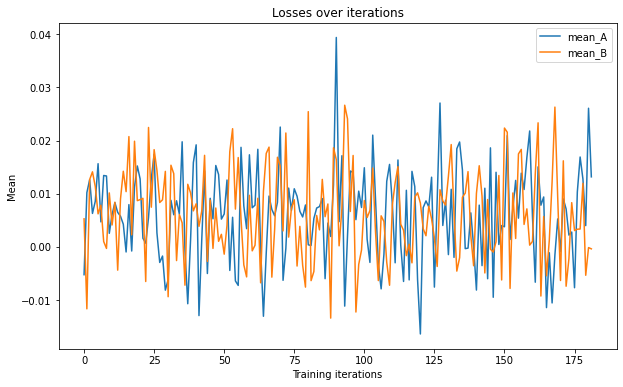

In [29]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Mean')
plt.plot(mean_A)
plt.plot(mean_B)
plt.legend(['mean_A', 'mean_B'])
plt.show()